Notebook's goal is to define an implementation of the initial diffusion model. The architecture is as it follows. 

Two forward branch, taking respectively $I_{tlc}$ and $I_{id}$, being the images from the Trusted Live Capture and the ID document. 
The forward branches, identical, will produce after a number of time steps T two noisy representations of the initial inputs, said respectively $N_{tlc}$ and $N_{id}$.

At the end of the of the two forward branches, a weighted average layer will compute the average $N_{avg} = \alpha N_{tlc} + \beta N_{id}$ that will represent the starting point of the reconstruction process.

The model should reconstruct the original subject if the $I_{id}$ is bona fide, while it should produce a dissimilar image if $I_{id}$ is a morph, possibly as close as possible to the second involved subject.

Source of initial implementation: https://github.com/dome272/Diffusion-Models-pytorch/blob/main/ddpm.py

In [19]:
import torch
import cv2 as cv
import matplotlib.pyplot as plt

import torch.nn as nn


In [2]:
STEPS = 200

In [3]:
# linear space noise, might be moved to a non-linear space later 
class NoiseScheduler:

    def __init__(self, noise_start, noise_end,steps):
        self.beta_start = noise_start
        self.beta_end = noise_end
        self.noise_steps = steps 
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

        #define alphas and precompute values ... 
        self.alphas = 1 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.inv_sqrt_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)




    def get_noise(self, t):
        return self.betas[t]

    def add_noise(self, img, noise, t):
        shape = img.shape
        batch_size = shape[0]

        sqrt_alpha_cumprod = self.sqrt_alpha_cumprod[t].reshape(batch_size)
        inv_sqrt_alpha_cumprod = self.inv_sqrt_alpha_cumprod[t].reshape(batch_size)

        for i in range(len(shape) - 1):
            sqrt_alpha_cumprod = sqrt_alpha_cumprod.unsqueeze(-1)
            inv_sqrt_alpha_cumprod = inv_sqrt_alpha_cumprod.unsqueeze(-1)

        return sqrt_alpha_cumprod * img + inv_sqrt_alpha_cumprod * noise
    
    def sample_previous_noise(self,xt,noise_prediction, t):
        
        x0 = (xt - self.inv_sqrt_alpha_cumprod[t] * noise_prediction) / self.sqrt_alpha_cumprod[t]
        x0 = torch.clamp(x0,-1,1)

        mean = xt - ( self.betas[t] * noise_prediction) / self.inv_sqrt_alpha_cumprod[t]
        mean = mean / torch.sqrt(self.alphas[t])

        if t == 0: 
            return mean, x0
        
        variance = (1 - self.alpha_cumprod[t-1]) / (1 - self.alpha_cumprod[t])
        variance = variance * self.betas[t]
        
        z = torch.randn(xt.shape)


        return mean + (variance ** .5) * z, x0


In [4]:
s = NoiseScheduler(0.000001, 0.15, STEPS) #noise from original paper

In [8]:
s.get_noise(int(STEPS / 2))

tensor(0.0754)

In [9]:
def auxShow(img, revert=True, show = True):
    if revert:
        cv.cvtColor(img,cv.COLOR_BGR2RGB)
        #img = img[:, :, ::-1] #reverting rgb 

    plt.imshow(img)
    plt.axis("off")
    if show:
        plt.show()

def grayShow(img, show = True):
    plt.imshow(img, cmap='gray',clim=(0,255))
    plt.axis("off")
    if show:
        plt.show()

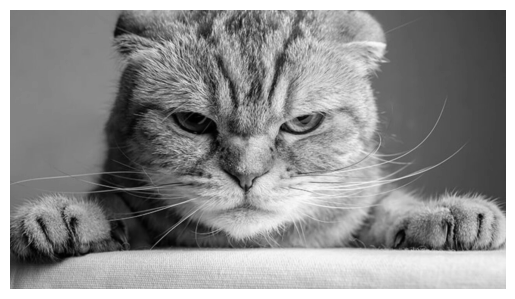

In [10]:
img = cv.imread("gato.jpg")
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
grayShow(gray_img)

In [11]:
gray_img.shape

(720, 1280)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003671802..255.00299].


torch.Size([1, 720, 1280, 3])


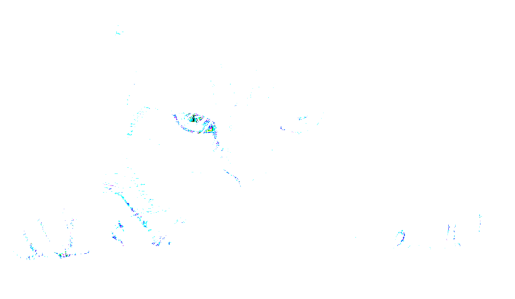

In [16]:
npimg = torch.from_numpy(img).reshape(1,img.shape[0],img.shape[1],img.shape[2]).float()
print(npimg.shape)
# noise is a sample tensor from a normal distribution with size img shape 0

noise = torch.randn(npimg.shape)

noised = s.add_noise(npimg,noise, int(0))

auxShow(noised[0].numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70426047..260.45944].


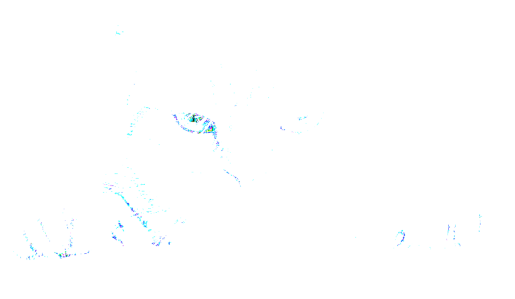

In [18]:

samp = s.sample_previous_noise(noised[0], noise, int(STEPS / 4))
auxShow(samp[0][0].numpy()) 

formulas for positional embeddings are:

$$[sin]$$

In [38]:
# defining positional embeddings ... 
# https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

# preso direttamente dalla reference 
def get_time_embeddings(time_steps, emb_dim):

    assert emb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
     
    factor = 10000 ** ((torch.arange(
        start=0, end=emb_dim // 2, dtype=torch.float32, device=time_steps.device) / (emb_dim // 2))
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, emb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb


get_time_embeddings(torch.as_tensor([1,1000]).long(), 10)

tensor([[ 8.4147e-01,  1.5783e-01,  2.5116e-02,  3.9811e-03,  6.3096e-04,
          5.4030e-01,  9.8747e-01,  9.9968e-01,  9.9999e-01,  1.0000e+00],
        [ 8.2688e-01,  9.8705e-01, -1.3877e-02, -7.4429e-01,  5.8992e-01,
          5.6238e-01,  1.6041e-01,  9.9990e-01, -6.6785e-01,  8.0746e-01]])

In [ ]:
# now i can define the blocks that i need ...

class resnetBlock(nn.module):
    
        def __init__(self, in_channels, out_channels, embdim, activation = nn.LeakyReLU()):
            super().__init__()
            self.activation = activation
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)


            self.time_embedding = nn.ModuleList([
            nn.Sequential(
                activation,
                nn.Linear(embdim, out_channels)
            )
        ])

            self.bn1 = nn.BatchNorm2d(out_channels)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.in_channels = in_channels
            self.out_channels = out_channels

            self.res_input_conv = nn.Conv2d(in_channels, out_channels, 1)
                
        def forward(self, x, t_embs):
            input = x
            x = self.bn1(x)
            x = self.activation(x)
            x = self.conv1(x)
            x = x + self.time_embedding(t_embs)[:, :, None, None]
            x = self.bn2(x)
            x = self.activation(x)
            x = self.conv2(x)
            x = x + self.residual_input_conv(input)
            return x
        
class selfAttentionBlock(nn.module):

    def __init__(self,in_channels, out_channels, headnums, activation = nn.LeakyReLU()):
        super().__init__()
        self.activation = activation
        self.norm = nn.BatchNorm2d(out_channels)
        self.satt = nn.MultiheadAttention(out_channels, headnums, batch_first=True)
        #self.inConv = nn.Conv2d(in_channels, out_channels, 1)
        
    def forward(self,x):
        input = x
        self.b, self.c, self.h, self.w = x.shape

        x = x.reshape(self.b, self.c, self.h * self.w) #reshape to linear ... 
        x = self.norm(x)
        x = x.transpose(1,2) # to put channels as last dimension ...
        x, _ = self.satt(x, x , x)

        #x = self.inConv(input) + x
        x = input + x
        return x


the three types of blocks that are needed for the Unet.

<img src="blocks.png" alt="the three types of blocks that are needed for the Unet." style="width: 50%;">


In [ ]:
# and now i can define the 3 types of block (downBlock, upBlock, middleBlock)
# check reference video for more details ...

class downBlock(nn.module):
    def __init__(self,in_channels, out_channels, emb_dim,num_layers = 1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, 4, 2, 1)

        self.resnet = nn.ModuleList([
            resnetBlock(in_channels if i == 0 else out_channels, out_channels, emb_dim)
            for i in range(num_layers)
        ])
        self.selfatt =nn.ModuleList([
            selfAttentionBlock(out_channels, out_channels, 4)
            for _ in range(num_layers)
            ])

    def forward(self, x, t_embs):
        for i in range(self.num_layers):
            x = self.resnet[i](x, t_embs) 
            x = self.selfatt[i](x)
        
        x = self.down_sample_conv(x)
        return x

In [ ]:
class middleBlock(nn.module):
    def __init__(self, in_channels, out_channels, emb_dim, num_layers=1):
        super().__init__()
        self.num_layers = num_layers

        self.initialResnet = resnetBlock(in_channels, out_channels, emb_dim)
        
        self.resnet = nn.ModuleList([
            resnetBlock(out_channels, out_channels, emb_dim)
            for _ in range(num_layers)
        ])
        self.selfatt = nn.ModuleList([
            selfAttentionBlock(out_channels, out_channels, 4)
            for _ in range(num_layers)
        ])

    def forward(self, x, t_embs):
        x = self.initialResnet(x, t_embs)
        
        for i in range(self.num_layers):
            x = self.selfatt[i](x)
            x = self.resnet[i](x, t_embs)
        return x

In [ ]:
#to check with code!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

class upBlock(nn.module):
    def __init__(self, in_channels, out_channels, emb_dim, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample_conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)

        self.resnet = nn.ModuleList([
            resnetBlock(out_channels, out_channels, emb_dim)
            for _ in range(num_layers)
        ])
        
        self.selfatt = nn.ModuleList([
            selfAttentionBlock(out_channels, out_channels, 4)
            for _ in range(num_layers)
        ])

    def forward(self, x, t_embs):
        for i in range(self.num_layers):
            x = self.resnet[i](x, t_embs)
            x = self.selfatt[i](x)
        x = self.up_sample_conv(x)
        return x

In [ ]:
# todo : data loader, data preprocessing, train func, eval func, traineval loop